In [1]:
# enumerate函数 产生枚举对象，是一个迭代器
[*enumerate(['a','b'])]

[(0, 'a'), (1, 'b')]

In [2]:
# 查看特征分布
def plot_distribution(data,):
    feature = data.name
    figure, ax = plt.subplots(figsize=(5,5))
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    # diy
    ax.hist(data, bins = 50)

In [3]:
# 时间转化为整形数字
def regularize_date(date):
    str=''
    for i in date.split('/'):
        if len(i) >= 2:
            str = i + str
        else:
            str = '0' + i +str
    return int(str)

In [40]:
# 处理文本信息,方便分词
import re
def removePunctuation(text):
    # punctuation 自定义re查询字符
    punctuation = '!,;:.?"\'(){}\[\]/#$%^&*\-+_1234567890`'
    text = re.sub(r'[{}]+'.format(punctuation),'',text)
    return text.strip().lower()

# 自定义分词函数（nltk用不了）
def split_word(word):
    word_clean = removePunctuation(word)
    return word_clean.split() # 默认传参分割任何空格

In [324]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# 取TFIDF模型中最大的值并转化为文本输出
# sentence 分好词的句子 [[],[]]
def getkeyword(sentence):
    # dictionary 按输入sentence生成的词典对象
    # new_corpus 计算语料库
    # corpus_tfidf 按照语料库生成的tfidf模型
    # 做成词典，给每个词打上ID
    dictionary = Dictionary(sentence)

    # 以 (词id,词频) 的方式记录每个词在每个sentence中出现的次数，
    # dictionary.doc2bow(i) i是一个"句子"，并且要求以list存放的分好词的"句子"，会返回每个词在该"句子"中的词频
    new_corpus = [dictionary.doc2bow(i) for i in sentence]
    
    # 训练TF-IDF模型
    tfidf = TfidfModel(new_corpus)
    
    # 从模型中获取每个词的tfidf, 以 (词id, TFIDF) 返回迭代器
    corpus_tfidf = tfidf[new_corpus]
    
    # 从每个句子中获取最大tfidf的词作为该句子的关键词
    keywords = []
    for line in corpus_tfidf:
        c = 0
        v = 0
        for i in line:
            if i[1] > c:
                c = i[1]
                v = i[0]
        # 最后希望输出词语，而不是词id
        keywords.append(dictionary.get(v))
    return keywords

### 数据清洗  
- 特征publication_date转数值型，方便喂模型和做归一化  
- 

In [31]:
# 基于MLP
# 引入特征工程所需要的的lib
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import time

In [325]:
# 导入数据
data_path      = 'Train_data.csv'
data_test_path = 'Test_data.csv'
data           = pd.read_csv(data_path, encoding='utf-8')
data_test      = pd.read_csv(data_test_path, encoding='utf-8')
#data.columns.apply(lambda x:strip(x))

# 除去字段空格
data.columns = [i.strip() for i in data.columns]
# 处理时间字段,转化为时间戳
data.publication_date = data.publication_date.apply(lambda x : regularize_date(x))

# 查看数据整体情况
display(data.head(),data.shape)

# 是否存在缺失值
display(data.isnull().any(axis = 0))

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,8253,Little Town on the Prairie (Little House #7),Laura Ingalls Wilder/Garth Williams,4.19,0060885432,9780060885434,eng,374,71853,646,20070101,HarperTrophy
1,11101,First Comes Love (Hot Water California #1),Christie Ridgway,3.81,0380818957,9780380818952,en-US,384,1051,47,20020101,Avon Books
2,28193,When Santa Fell to Earth,Cornelia Funke/Paul Howard/Oliver G. Latsch,3.76,043978204X,9780439782043,eng,167,1840,245,20060110,Chicken House / Scholastic
3,25047,The Case of the Stinky Science Project (Jigsaw...,James Preller/John Speirs/James Preller,3.83,0439114284,9780439114288,en-US,80,162,11,20010103,Scholastic Paperbacks
4,17800,Dance Dance Dance,Haruki Murakami,4.04,0099448769,9780099448761,eng,393,50169,2117,20020702,Vintage


(10000, 12)

bookID                False
title                 False
authors               False
average_rating        False
isbn                  False
isbn13                False
language_code         False
num_pages             False
ratings_count         False
text_reviews_count    False
publication_date      False
publisher             False
dtype: bool

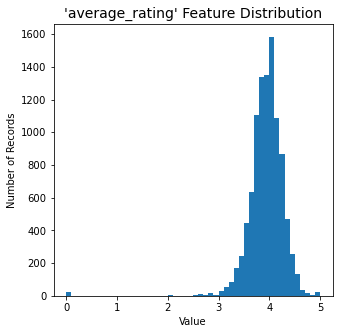

In [7]:
# 查看预测目标、即感兴趣的特征的分布情况
plot_distribution(data.average_rating, )

0       6.472346
1       3.871201
2       5.505332
3       2.484907
4       7.658228
          ...   
9995    2.079442
9996    6.068426
9997    2.397895
9998    0.000000
9999    2.079442
Name: log_text_reviews_count, Length: 10000, dtype: float64

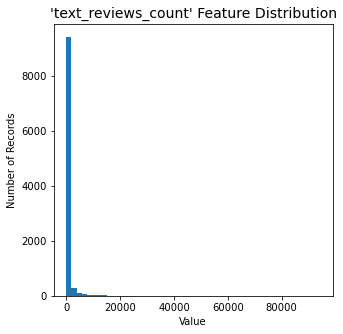

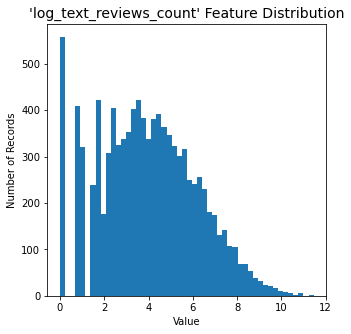

In [8]:
# text_reviews_count 评论数量
plot_distribution(data.text_reviews_count, )
dealt_data = data.text_reviews_count.apply(lambda x:np.log(x+1))
dealt_data.name = 'log_text_reviews_count'
display(dealt_data)
plot_distribution(dealt_data, )

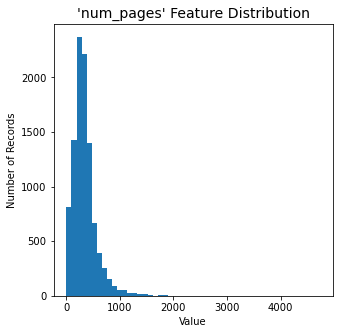

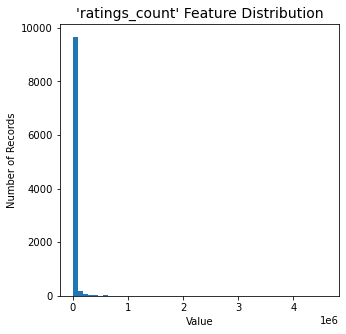

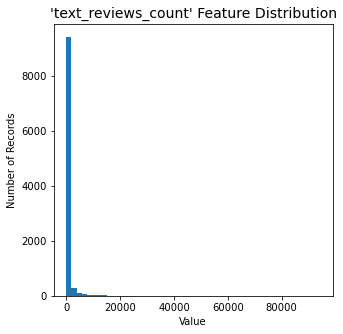

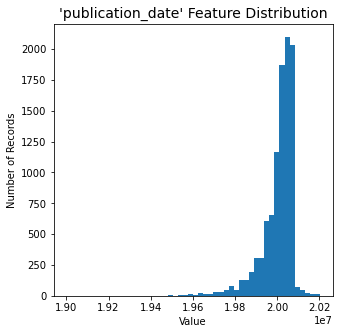

In [9]:
# 先重点关注几个continuous data特征
for i in ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date']:
    try:
        plot_distribution(data[i], )
    except BaseException as e:
        print(e)

### 文本处理

In [166]:
# 1.2.1 分词预训练词向量
title_data_train = data.title
title_data_test = data_test.title
title_data = pd.concat([title_data_train, title_data_test], ignore_index=1)
sentence = []
for i in title_data: 
    sentence.append(split_word(i))

print('分词结束,取top3句子检查：\n', sentence[:3])

分词结束,取top3句子检查：
 [['little', 'town', 'on', 'the', 'prairie', 'little', 'house'], ['first', 'comes', 'love', 'hot', 'water', 'california'], ['when', 'santa', 'fell', 'to', 'earth']]


In [48]:
# 1.2.2 把文本数据转化词向量
# min_count = 1 由于数据集很小,所以有1个就会进入计算,防止词丢失
w2v_model = Word2Vec(sentences=sentence, size=50, min_count=1)
w2v_model.save("bdc_word2vec.model")
w2v_model = Word2Vec.load('bdc_word2vec.model')

In [153]:
print('查看当前word2vec模型下,computer和my的表达向量:\n', w2v_model.wv[['computer', 'my']])

查看当前word2vec模型下,computer和my的表达向量:
 [[-1.0254054e-01  7.5605186e-03  3.5716433e-02 -7.0665278e-02
  -2.7054911e-03 -8.9421626e-03  2.2852637e-02  9.6849941e-02
  -4.1761585e-03 -2.1382367e-02  4.1080862e-02  5.1465556e-02
  -3.9826766e-02  5.2590970e-02 -1.1832463e-01  5.4354012e-02
  -9.1033340e-02  1.2141986e-02  5.4736007e-02  2.6847109e-02
   2.4238614e-02 -5.1816750e-02  4.8214369e-02  1.4790565e-01
  -2.3025410e-02 -4.9665105e-03  6.3396394e-02 -4.6596628e-02
   5.2443538e-02  6.0891253e-03 -1.1508133e-02 -2.6002036e-02
   2.2882901e-02  5.3212076e-02 -3.4974642e-02  2.6613107e-02
  -2.3301404e-03 -4.0044056e-04 -5.4775723e-03  4.2863514e-02
   7.3326938e-02 -3.5560071e-02  1.4385156e-02 -7.1099475e-02
  -6.4906077e-03  3.4777772e-02 -5.0860558e-02  5.9692759e-02
   3.0494826e-02 -7.4224144e-02]
 [-1.0419167e+00  7.5783670e-02  3.1532636e-01 -6.7594707e-01
  -3.3263408e-02 -1.3175386e-01  2.3052005e-01  1.0344397e+00
  -7.0143580e-02 -1.3684013e-01  4.1857877e-01  5.6557393e-01
  

In [143]:
# 抽取关键词（每句中TF-IDF最大值的词）
# corpus_tfidf = tfidf[new_corpus]
# 获取关键词 keywords
keywords = getkeyword(sentence)
keywords_vec = w2v_model.wv[keywords]

In [145]:
type(keywords_vec)

numpy.ndarray

In [146]:
len(keywords_vec)

11000

In [167]:
# 把原title的关键词，转化为N维词向量表示
title_data = keywords_vec[:len(title_data_train)]
title_data_test = keywords_vec[-len(title_data_test):]

检查词向量表达是否对齐,
抽查关键词查找是否相对合理,

In [169]:
title_data_test[0]

array([-0.03141074, -0.00116384,  0.01055623, -0.01409011,  0.00836165,
       -0.00642777,  0.01445252,  0.03402783, -0.00926357, -0.00604288,
        0.01505413,  0.02102763, -0.01447519,  0.00941524, -0.03135257,
        0.01252999, -0.02017596,  0.01193538,  0.02110334, -0.00024581,
        0.00425608, -0.01035169,  0.00437745,  0.0388747 , -0.00712774,
        0.00409723,  0.00977561, -0.01951378,  0.02432415,  0.00987962,
       -0.00417582, -0.0044214 ,  0.01482423,  0.01303068, -0.01044828,
        0.00316265, -0.00731089,  0.01020455,  0.00646794, -0.00065986,
        0.01851091, -0.00437974,  0.01275494, -0.01249666,  0.00343833,
        0.01648898, -0.00180637,  0.00753103,  0.00272681, -0.01464701],
      dtype=float32)

In [189]:
keywords_vec[10000]

array([-0.03141074, -0.00116384,  0.01055623, -0.01409011,  0.00836165,
       -0.00642777,  0.01445252,  0.03402783, -0.00926357, -0.00604288,
        0.01505413,  0.02102763, -0.01447519,  0.00941524, -0.03135257,
        0.01252999, -0.02017596,  0.01193538,  0.02110334, -0.00024581,
        0.00425608, -0.01035169,  0.00437745,  0.0388747 , -0.00712774,
        0.00409723,  0.00977561, -0.01951378,  0.02432415,  0.00987962,
       -0.00417582, -0.0044214 ,  0.01482423,  0.01303068, -0.01044828,
        0.00316265, -0.00731089,  0.01020455,  0.00646794, -0.00065986,
        0.01851091, -0.00437974,  0.01275494, -0.01249666,  0.00343833,
        0.01648898, -0.00180637,  0.00753103,  0.00272681, -0.01464701],
      dtype=float32)

In [188]:
keywords[10020]

'crisis'

In [187]:
data_test.title[20]

'Identity Crisis'

### one-hot

In [307]:
# 先简化下数据集吧, 先不处理publisher和authors两个字段
# 构建新的数据集，先drop了出版者和作者，看看词向量效果如何
new_data = data.drop(columns=['title', 'isbn', 'bookID', 'publisher', 'authors'])
test = pd.DataFrame(title_data, columns=[('title_vec_'+str(i)) for i in range(len(title_data[0]))])

In [308]:
new_data.head(5)

,average_rating,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date
0,4.19,9780060885434,eng,374,71853,646,20070101
1,3.81,9780380818952,en-US,384,1051,47,20020101
2,3.76,9780439782043,eng,167,1840,245,20060110
3,3.83,9780439114288,en-US,80,162,11,20010103
4,4.04,9780099448761,eng,393,50169,2117,20020702


In [309]:
display(test.head(5))
print(len(test))

,title_vec_0,title_vec_1,title_vec_2,title_vec_3,title_vec_4,title_vec_5,title_vec_6,title_vec_7,title_vec_8,title_vec_9,...,title_vec_40,title_vec_41,title_vec_42,title_vec_43,title_vec_44,title_vec_45,title_vec_46,title_vec_47,title_vec_48,title_vec_49
0,-0.781016,0.049052,0.247506,-0.508720,-0.028404,-0.098965,0.180613,0.765649,-0.035719,-0.105581,...,0.569125,-0.321906,0.155105,-0.470583,-0.121234,0.241099,-0.332592,0.529952,0.185461,-0.615939
1,-0.048879,0.011986,0.016007,-0.040465,0.006830,-0.000512,0.003227,0.055370,0.001014,-0.002840,...,0.029633,-0.026437,0.004754,-0.025743,-0.009082,0.018027,-0.031640,0.026373,0.008810,-0.041538
2,-0.011812,0.009927,-0.000534,-0.016062,0.008028,-0.002372,0.011658,0.019914,-0.002366,0.008002,...,0.005025,-0.009147,0.007955,-0.015855,0.005110,0.001280,-0.000633,0.008046,0.010313,-0.013177
3,-0.014622,-0.000345,-0.003417,-0.011921,-0.003629,-0.010856,0.006182,0.012500,-0.001906,-0.002113,...,0.011988,-0.016520,-0.002324,-0.017745,0.005043,-0.004256,-0.008751,0.004202,-0.001869,-0.012708
4,-0.177726,0.020315,0.056250,-0.116738,-0.016646,-0.028050,0.033655,0.180455,-0.001607,-0.023277,...,0.129878,-0.081047,0.037761,-0.108831,-0.036260,0.063717,-0.078933,0.117864,0.047689,-0.135561


10000


In [310]:
new_data = pd.concat([new_data , test], axis=1)
display(new_data)

,average_rating,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,title_vec_0,title_vec_1,title_vec_2,...,title_vec_40,title_vec_41,title_vec_42,title_vec_43,title_vec_44,title_vec_45,title_vec_46,title_vec_47,title_vec_48,title_vec_49
0,4.19,9780060885434,eng,374,71853,646,20070101,-0.781016,0.049052,0.247506,...,0.569125,-0.321906,0.155105,-0.470583,-0.121234,0.241099,-0.332592,0.529952,0.185461,-0.615939
1,3.81,9780380818952,en-US,384,1051,47,20020101,-0.048879,0.011986,0.016007,...,0.029633,-0.026437,0.004754,-0.025743,-0.009082,0.018027,-0.031640,0.026373,0.008810,-0.041538
2,3.76,9780439782043,eng,167,1840,245,20060110,-0.011812,0.009927,-0.000534,...,0.005025,-0.009147,0.007955,-0.015855,0.005110,0.001280,-0.000633,0.008046,0.010313,-0.013177
3,3.83,9780439114288,en-US,80,162,11,20010103,-0.014622,-0.000345,-0.003417,...,0.011988,-0.016520,-0.002324,-0.017745,0.005043,-0.004256,-0.008751,0.004202,-0.001869,-0.012708
4,4.04,9780099448761,eng,393,50169,2117,20020702,-0.177726,0.020315,0.056250,...,0.129878,-0.081047,0.037761,-0.108831,-0.036260,0.063717,-0.078933,0.117864,0.047689,-0.135561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,9780062700254,eng,768,66,7,19912412,-0.012579,0.007327,0.003723,...,0.001122,-0.005138,0.008148,0.004300,0.003952,0.006022,-0.008254,-0.007926,0.002103,-0.003233
9996,3.46,9780571164660,eng,161,6994,431,20002607,-0.267628,0.020251,0.083938,...,0.186498,-0.103351,0.044105,-0.173164,-0.045981,0.086150,-0.102021,0.183847,0.069892,-0.223567
9997,4.08,9780679602712,eng,425,81,10,19970508,-0.042753,0.012650,0.024437,...,0.037432,-0.009389,0.003934,-0.025610,0.001612,0.005221,-0.029295,0.040801,0.009835,-0.038291
9998,3.90,9780307376640,spa,432,2,0,20060711,-0.013571,0.008466,-0.001778,...,0.015887,0.001498,0.007012,-0.005831,0.007359,0.008683,0.001039,0.002539,0.001419,-0.009774


In [ ]:
MLPRegression(a, b, c)

eng       8001
en-US     1285
en-GB      189
spa        187
fre        130
ger         85
codex2      79
jpn         44
Name: language_code, dtype: int64

In [323]:
# one-hot encode
from sklearn.preprocessing import LabelEncoder

# 先对language_encode进行预处理，
# 首先将少量编码类型合并
# 用正则方式实现类SQL where方法
get_bool = new_data['language_code'].str.contains(r'^(?:(?!eng|en-US|en-GB|spa|fre|ger|jpn).)*$')

new_data['language_code'][get_bool] = 'codex2'

display(new_data)
display(new_data['language_code'].value_counts())

<ipython-input-323-f6d02adaad98>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['language_code'][get_bool] = 'codex2'


,average_rating,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,title_vec_0,title_vec_1,title_vec_2,...,title_vec_40,title_vec_41,title_vec_42,title_vec_43,title_vec_44,title_vec_45,title_vec_46,title_vec_47,title_vec_48,title_vec_49
0,4.19,9780060885434,eng,374,71853,646,20070101,-0.781016,0.049052,0.247506,...,0.569125,-0.321906,0.155105,-0.470583,-0.121234,0.241099,-0.332592,0.529952,0.185461,-0.615939
1,3.81,9780380818952,en-US,384,1051,47,20020101,-0.048879,0.011986,0.016007,...,0.029633,-0.026437,0.004754,-0.025743,-0.009082,0.018027,-0.031640,0.026373,0.008810,-0.041538
2,3.76,9780439782043,eng,167,1840,245,20060110,-0.011812,0.009927,-0.000534,...,0.005025,-0.009147,0.007955,-0.015855,0.005110,0.001280,-0.000633,0.008046,0.010313,-0.013177
3,3.83,9780439114288,en-US,80,162,11,20010103,-0.014622,-0.000345,-0.003417,...,0.011988,-0.016520,-0.002324,-0.017745,0.005043,-0.004256,-0.008751,0.004202,-0.001869,-0.012708
4,4.04,9780099448761,eng,393,50169,2117,20020702,-0.177726,0.020315,0.056250,...,0.129878,-0.081047,0.037761,-0.108831,-0.036260,0.063717,-0.078933,0.117864,0.047689,-0.135561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,9780062700254,eng,768,66,7,19912412,-0.012579,0.007327,0.003723,...,0.001122,-0.005138,0.008148,0.004300,0.003952,0.006022,-0.008254,-0.007926,0.002103,-0.003233
9996,3.46,9780571164660,eng,161,6994,431,20002607,-0.267628,0.020251,0.083938,...,0.186498,-0.103351,0.044105,-0.173164,-0.045981,0.086150,-0.102021,0.183847,0.069892,-0.223567
9997,4.08,9780679602712,eng,425,81,10,19970508,-0.042753,0.012650,0.024437,...,0.037432,-0.009389,0.003934,-0.025610,0.001612,0.005221,-0.029295,0.040801,0.009835,-0.038291
9998,3.90,9780307376640,spa,432,2,0,20060711,-0.013571,0.008466,-0.001778,...,0.015887,0.001498,0.007012,-0.005831,0.007359,0.008683,0.001039,0.002539,0.001419,-0.009774


eng       8001
en-US     1285
en-GB      189
spa        187
fre        130
ger         85
codex2      79
jpn         44
Name: language_code, dtype: int64

构建训练和测试环境

In [23]:
from sklearn.neural_network import MLPClassifier

In [90]:
# TF-IDF based on gensim
# 文档 > 文本 > 词
# TF:每个词的次数/该文本中出现最多的词的次数
# IDF：log_2(N/df), df:整个文档中包含某词的文本个数

# 流程：分词->建语料库->练tfidf模型->输入语料->输出tfidf值
from gensim.corpora import Dictionary
from gensim.models import TfidfModel


# 做成词典，给每个词打上ID
dictionary = Dictionary(sentence)

# 以 (词id,词频) 的方式记录每个词在每个sentence中出现的次数，
# dictionary.doc2bow(text) 输入以list存放的分好词的"句子"，并返回每个词在该文本的词频
new_corpus = [dictionary.doc2bow(text) for text in sentence]

# 
print(new_corpus[:2])
print(sentence[:2])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[['little', 'town', 'on', 'the', 'prairie', 'little', 'house'], ['first', 'comes', 'love', 'hot', 'water', 'california']]


In [75]:
# dictionary.doc2bow 查阅已生成字典,输出为 (词id-词频)
#dictionary.doc2bow(['computer','computer','first','first','first'])
dictionary.doc2bow(['little','computer'])

[(1, 1), (750, 1)]

In [136]:
# 通过词id找到指定的词
dictionary.get(1)

'little'

In [135]:
# 通过词找到指定id
dictionary.doc2idx(['little'])

[1]

In [91]:
# 训练TF-IDF模型
tfidf = TfidfModel(new_corpus)
tfidf.save("bdc_tfidf.model")
tfidf = TfidfModel.load("bdc_tfidf.model")
# print(type(tfidf)) :: <class 'gensim.models.tfidfmodel.TfidfModel'>

In [138]:
# 抽取关键词（每句中TF-IDF最大值的词）
# corpus_tfidf = tfidf[new_corpus]
# 获取关键词 keywords
keywords = getkeyword(sentence)